In [2]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


# MANGA Dataset
---

### Preprocessing

In [ ]:
# Training and Validation data
transforms = v2.Compose([
    v2.Resize((256, 256)), # Resize to 224x224
    v2.ToTensor(),
    v2.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]), # Normalize
])

# Create Datasets for Training and Validation
PATH = './animeface-character-dataset/animeface-character-dataset' 
train_dataset = ImageFolder(PATH, transform=transforms)

In [17]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 9754
    Root location: ./animeface-character-dataset/animeface-character-dataset
    StandardTransform
Transform: Compose(
                 Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToTensor()
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
           )

In [18]:
# Create a DataLoader for batching and shuffling the data
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Generator
---

In [3]:
class Generator(nn.Module):
    def __init__(self, maps = 64, noise_size = 128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(noise_size, maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(maps * 8),
            nn.ReLU(True),
            # state size. (maps*8) x 4 x 4
            nn.ConvTranspose2d(maps * 8, maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 4),
            nn.ReLU(True),
            # state size. (maps*4) x 8 x 8
            nn.ConvTranspose2d(maps * 4, maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 2),
            nn.ReLU(True),
            # state size. (maps*2) x 16 x 16
            nn.ConvTranspose2d(maps * 2, maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps),
            nn.ReLU(True),
            # state size. (maps) x 32 x 32
            nn.ConvTranspose2d(maps, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self, x):
        return self.model(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


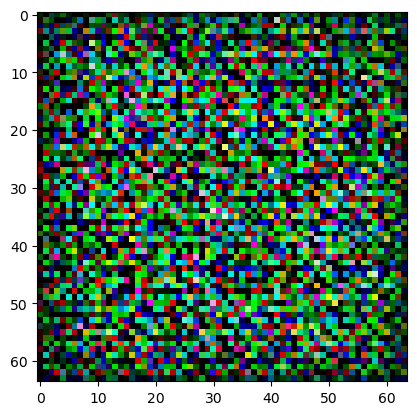

In [45]:
generator = Generator()
noise = torch.randn(64, 128, 1, 1)
output = generator(noise)
plt.imshow(output[0].detach().numpy().transpose(1, 2, 0))
plt.show()

# Discriminator
---

In [34]:
class Discriminator(nn.Module):
    def __init__(self, maps = 64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(3, maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # state size. (maps) x 32 x 32
            nn.Conv2d(maps, maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # state size. (maps*2) x 16 x 16
            nn.Conv2d(maps * 2, maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # state size. (maps*8) x 4 x 4
            nn.Conv2d(maps * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [46]:
discriminator = Discriminator()
output_d = discriminator(output)
output_d

tensor([[[[0.6075, 0.3806, 0.4990, 0.4379, 0.4231],
          [0.5408, 0.4539, 0.5586, 0.4630, 0.5494],
          [0.3554, 0.3435, 0.4690, 0.4869, 0.5549],
          [0.2616, 0.5271, 0.4130, 0.4545, 0.5632],
          [0.4481, 0.4940, 0.6139, 0.4284, 0.5136]]],


        [[[0.4132, 0.4468, 0.6638, 0.6183, 0.5688],
          [0.4599, 0.5333, 0.6252, 0.5226, 0.3977],
          [0.6360, 0.5129, 0.6262, 0.4879, 0.4190],
          [0.5507, 0.4708, 0.5406, 0.5785, 0.5267],
          [0.4528, 0.4694, 0.3523, 0.3578, 0.5663]]],


        [[[0.4657, 0.4571, 0.5802, 0.5264, 0.4984],
          [0.5990, 0.5603, 0.2630, 0.3350, 0.3294],
          [0.4358, 0.3714, 0.4963, 0.5274, 0.6185],
          [0.6444, 0.4800, 0.8225, 0.7243, 0.3793],
          [0.4199, 0.5659, 0.3630, 0.6019, 0.3474]]],


        ...,


        [[[0.4533, 0.4598, 0.4749, 0.7028, 0.3195],
          [0.6826, 0.4316, 0.5109, 0.4584, 0.5623],
          [0.3566, 0.4879, 0.5252, 0.4478, 0.2897],
          [0.5941, 0.6012, 0.6116, 0.

# Compiler
---

In [ ]:
class DCGAN(nn.Module):
    def __init__(self, discriminator, generator, latent_size):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_size = latent_size
    
    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss = nn.BCELoss()
        self.d_loss_metric = torch.tensor(0.0)
        self.g_loss_metric = torch.tensor(0.0)

    def train_step(self, real_images):
        batch_size = real_images.size(0)
        # Adversarial ground truths
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train Generator
        self.g_optimizer.zero_grad()
        # Sample noise as generator input
        z = torch.randn(batch_size, self.latent_size, 1, 1).to(device)
        # Generate a batch of images
        gen_imgs = self.generator(z)
        # Loss measures generator's ability to fool the discriminator
        g_loss = self.loss(self.discriminator(gen_imgs), valid)
        g_loss.backward()
        self.g_optimizer.step()

        # Train Discriminator
        self.d_optimizer.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        real_loss = self.loss(self.discriminator(real_images), valid)
        fake_loss = self.loss(self.discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        self.d_optimizer.step()

        self.d_loss_metric = d_loss
        self.g_loss_metric = g_loss
        return {"d_loss": d_loss, "g_loss": g_loss}